# Interactive Modules

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

### Scenario Setup

In [2]:
import mantrap
import numpy as np
import torch

env = mantrap.environment.PotentialFieldEnvironment(
    ego_type=mantrap.agents.IntegratorDTAgent, 
    ego_position=torch.zeros(2), 
    ego_velocity=torch.zeros(2),
    dt=0.4
)
env.add_ado(position=torch.tensor([-5, 2.0]), velocity=torch.tensor([1, 0]))

# Compute ego trajectories to base comparison on.
t_horizon = 9
ego_controls = [
    torch.zeros((t_horizon, 2), requires_grad=True),
    torch.tensor([[0.0, -1.0] * t_horizon], requires_grad=True).view(t_horizon, 2),
    torch.tensor([[1.0, -1.0] * t_horizon], requires_grad=True).view(t_horizon, 2),
    torch.tensor([[-1.0, 0.0] * t_horizon], requires_grad=True).view(t_horizon, 2),
    torch.tensor([[0.0, 1.0] * t_horizon], requires_grad=True).view(t_horizon, 2),
]
colors = ["red", "blue", "green", "yellow", "orange"]
assert len(ego_controls) == len(colors)

n = len(ego_controls)
ego_trajectories = [env.ego.unroll_trajectory(controls, dt=env.dt) for controls in ego_controls]

# Compute trajectory predictions in response to different ego actions.
ado_trajectory_wo = env.predict_wo_ego(t_horizon=t_horizon).squeeze()
ado_trajectories_w = [env.predict_w_trajectory(trajectory).squeeze() for trajectory in ego_trajectories]

In [3]:
from mantrap.visualization import visualize_trajectories

labels_all = ["ado_wo", *[f"ado_{i + 1}" for i in range(n)], *[f"ego_{i + 1}" for i in range(n)]]
colors_all = ["black", *colors, *colors]

HTML(visualize_trajectories([ado_trajectory_wo, *ado_trajectories_w, *ego_trajectories],
                             labels=labels_all, colors=colors_all, env_axes=env.axes))

### Sample-wise Position-Based Interactive Objective

In [4]:
cost = mantrap.modules.baselines.InteractionPositionModule(env=env, t_horizon=t_horizon)

print("Objectives")
for trajectory, color in zip(ego_trajectories, colors):
    objective = cost.objective(trajectory, ado_ids=env.ado_ids, tag="test")
    print(f"{color} ==> {objective}")
    
print("\nGradients (L2-norm)")
for controls, trajectory, color in zip(ego_controls, ego_trajectories, colors):
    gradient = np.linalg.norm(cost.gradient(trajectory, grad_wrt=controls, ado_ids=env.ado_ids, tag="test"))
    print(f"{color} ==> {gradient}")

Objectives
red ==> 21.614931106567383
blue ==> 18.49272346496582
green ==> 14.293777465820312
yellow ==> 24.226463317871094
orange ==> 32.00990295410156

Gradients (L2-norm)
red ==> 4.242565155029297
blue ==> 2.7836191654205322
green ==> 2.503732681274414
yellow ==> 4.937591552734375
orange ==> 7.024472713470459


### Projection Probability Interactive Objective

In [5]:
cost = mantrap.modules.InteractionProbabilityModule(env=env, t_horizon=t_horizon, weight=1.0)

print("Objectives")
for trajectory, color in zip(ego_trajectories, colors):
    objective = cost.objective(trajectory, ado_ids=env.ado_ids, tag="test")
    print(f"{color} ==> {objective}")
    
print("\nGradients (L2-norm)")
for controls, trajectory, color in zip(ego_controls, ego_trajectories, colors):
    gradient = np.linalg.norm(cost.gradient(trajectory, grad_wrt=controls, ado_ids=env.ado_ids, tag="test"))
    print(f"{color} ==> {gradient}")

Objectives
red ==> -8.91556453704834
blue ==> -9.935378074645996
green ==> -10.80612564086914
yellow ==> -8.383356094360352
orange ==> -8.745085716247559

Gradients (L2-norm)
red ==> 0.8781304955482483
blue ==> 0.9050135612487793
green ==> 0.677577018737793
yellow ==> 1.0049480199813843
orange ==> 0.757636547088623


### Comparison

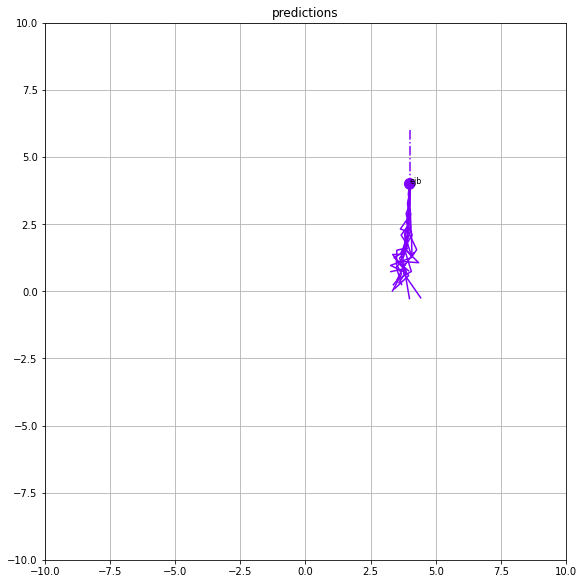

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

import mantrap
import numpy as np
import torch

env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                     ego_position=torch.tensor([-4, 0]), 
                                     ego_velocity=torch.ones(2))
env.add_ado(position=torch.tensor([4, 4]), velocity=torch.tensor([0, -1]))

env.visualize_prediction_wo_ego(t_horizon=10)
plt.show()

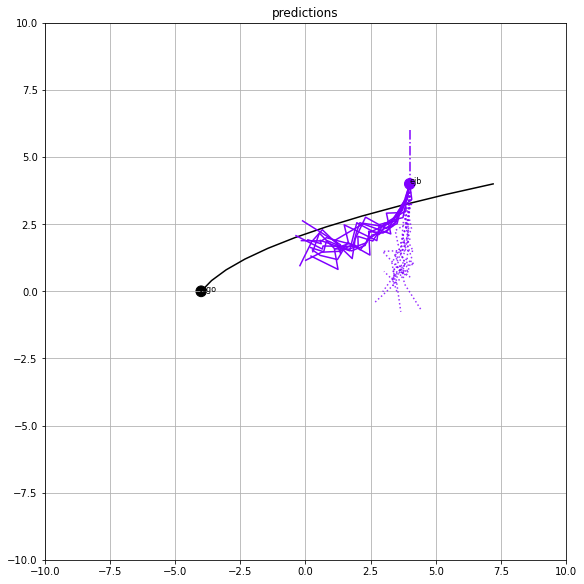

In [3]:
ego_controls = torch.stack([torch.tensor([1, 0])] * 10)
ego_trajectory = env.ego.unroll_trajectory(ego_controls, dt=env.dt)
env.visualize_prediction(ego_trajectory)
plt.show()

In [5]:
env = mantrap.environment.Trajectron(
    ego_type=mantrap.agents.IntegratorDTAgent, 
    ego_position=torch.zeros(2), 
    ego_velocity=torch.zeros(2),
    dt=0.4
)
env.add_ado(position=torch.tensor([-5, 2.0]), velocity=torch.tensor([1, 0]))
env.add_ado(position=torch.tensor([-2, -2.0]), velocity=torch.tensor([1, 1]))


goal = torch.tensor([8, 0])
modules = [mantrap.modules.GoalNormModule, mantrap.modules.InteractionProbabilityModule]
solver = mantrap.solver.SGradSolver(env, goal=goal, modules=modules, is_logging=True)
solver.solve(time_steps=10)

HTML(solver.visualize_scenes())